In [1]:
from audiofile import AudioFile

In [2]:
guitar = AudioFile('test', 'guitar_acoustic', 6)
guitar.fundamental_freq = 110  # A2
piano = AudioFile('train', 'keyboard_acoustic', 27)
piano.fundamental_freq = 55  # A1

## Guitar

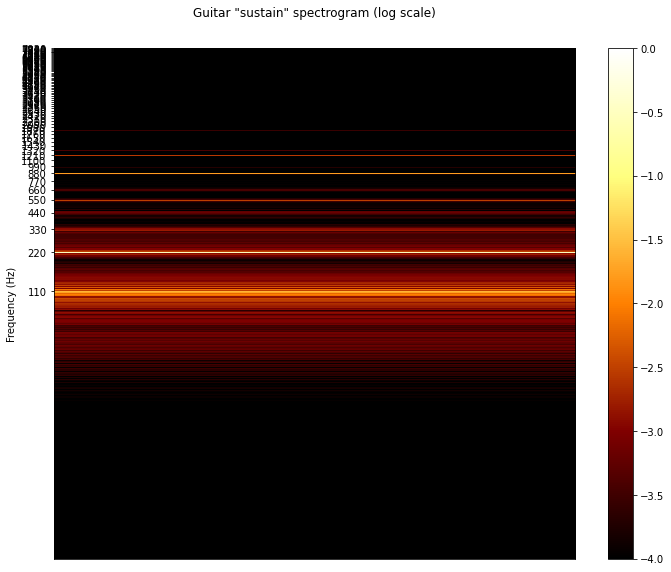

(1, 1296)


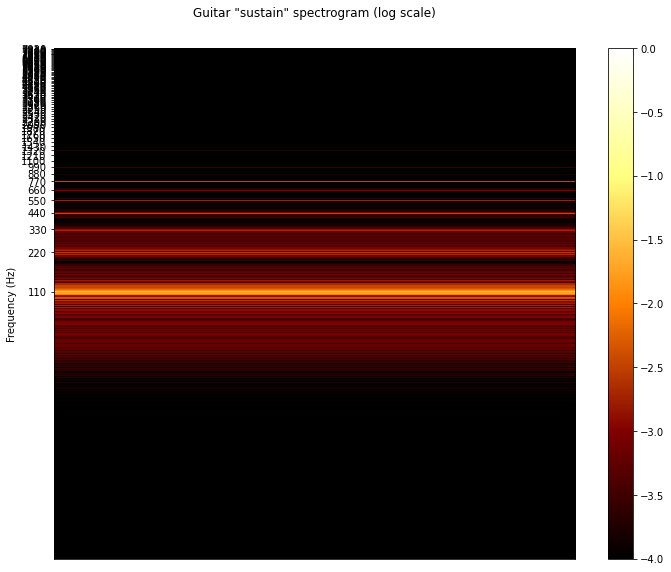

(1, 12965)


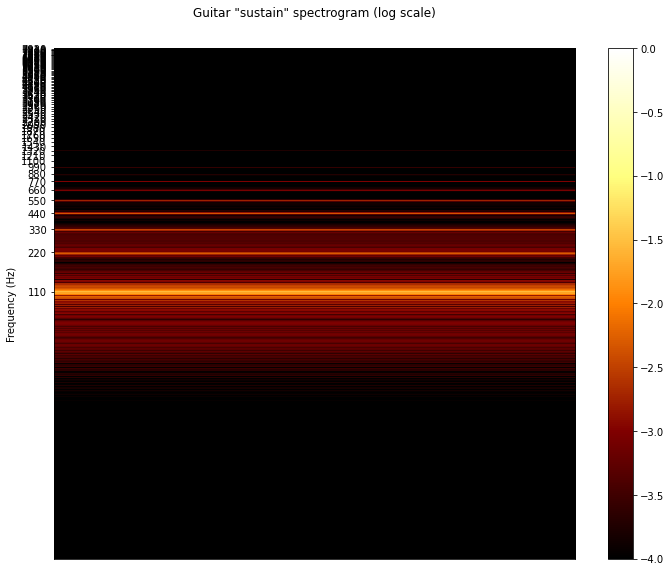

(1, 129657)


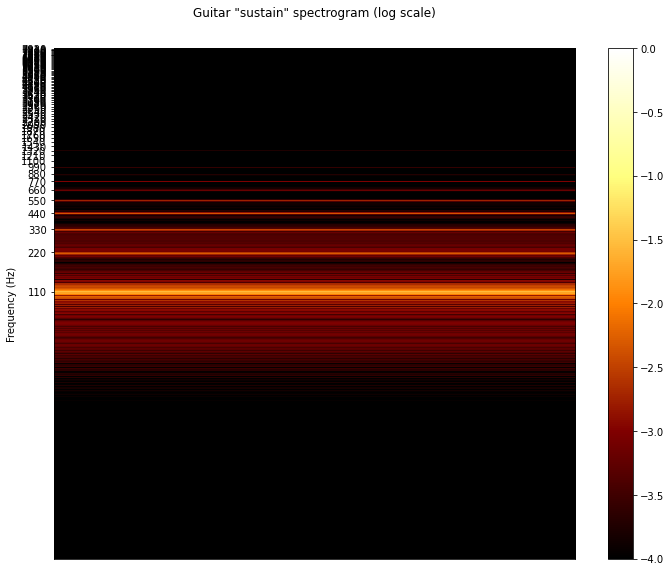

(1, 249708)


In [3]:
# Load audio and create spectrogram
guitar.load_audio(start=0.5)
guitar.audio_to_spectrogram(spec_thresh=4)

for resolution in [100, 1000, 10000, 19259]:
    guitar.spectrogram_to_log(guitar.spectrogram, resolution=resolution)
    guitar.plot_spectrogram(guitar.spectrogram_log, 'Guitar "sustain" spectrogram (log scale)',
                            log_scale=True, max_freq=-1, figsize=(10, 8))
    print(guitar.spectrogram_log.shape)

## Piano

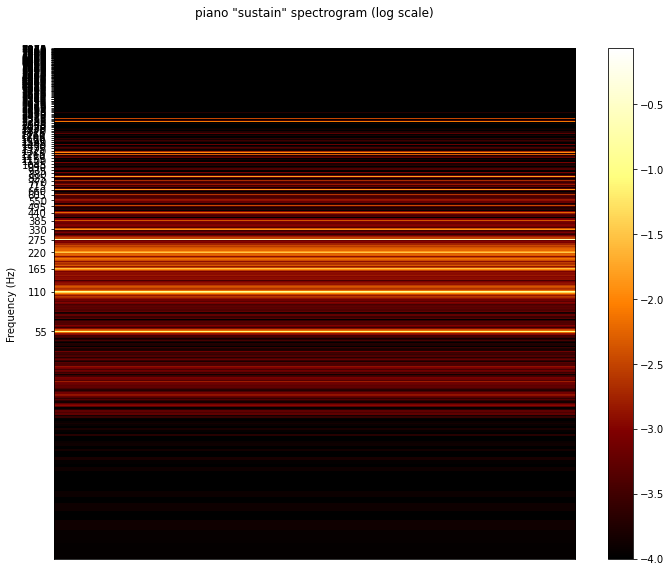

(1, 1296)


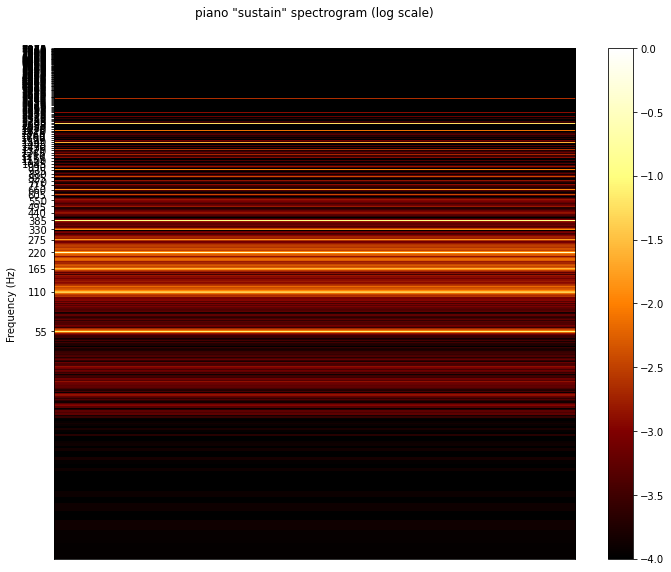

(1, 12965)


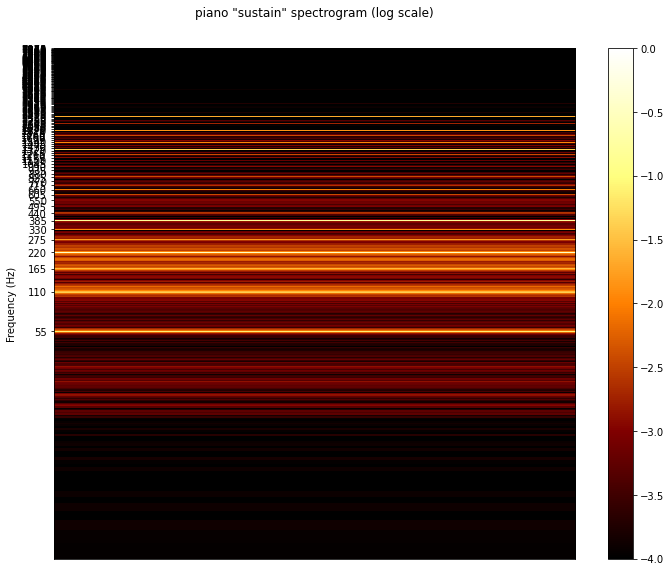

(1, 129657)


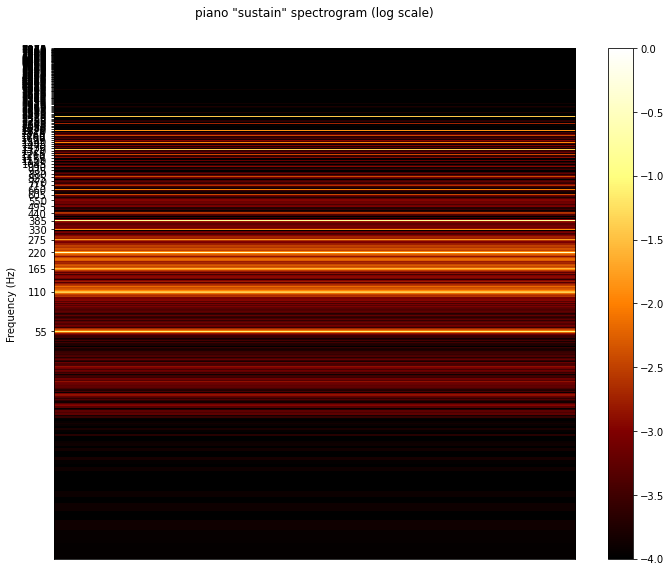

(1, 249708)


In [5]:
# Load audio and create spectrogram
piano.load_audio(start=1)
piano.audio_to_spectrogram(spec_thresh=4)

for resolution in [100, 1000, 10000, 19259]:
    piano.spectrogram_to_log(piano.spectrogram, resolution=resolution)
    piano.plot_spectrogram(piano.spectrogram_log, 'piano "sustain" spectrogram (log scale)',
                            log_scale=True, max_freq=-1, figsize=(10, 8))
    print(piano.spectrogram_log.shape)